# K-Nearest Neighbours Applied to Financial Time Series

### Problem Scope

Let  $X = \left[\;x_1,x_2,...,x_t\;\right] \subset \mathbb{R}^t$ be the time series from an asset's logarithmic returns.
 $\;$
We are interested in forecast the next $p$ returns in two subsequential manners:

$\;$
(1) Forecast the value of the returns, 

$\;[\hat{x}_{t+1}, \hat{x}_{t+2},..., \hat{x}_{t+p}] \subset \mathbb{R}^{p}$ . 


$\;$
(2) Forecast the signal (a.k.a., the direction) of the return in a given day.

$\;[sg(\hat{x}_{t+1}), sg(\hat{x}_{t+2}),..., sg(\hat{x}_{t+p})] \subset \{-1,1\}^{p} \;$ 


$\;$
where $sg$ is a functon, defined as

$sg: \mathbb{R} \rightarrow \{-1,1\} $  

$ x < 0\;\leftrightarrow\;sg(x) = -1\;$ and $\; x \geq 0\;\leftrightarrow\;sg(x) = 1.$

### KNN Algorithm

Let $\bold{n}$ be the length of each string of observations (vectors) and $\bold{m}$ the cardinality (or, quantity) of these observations as follows below:

$
X_{[m\;,\; n]} = 
\begin{bmatrix}
x_{t-(n)} & x_{t-(n-1)} & ..  & ..& x_{t-(1)}   \\
x_{t-(n+1)} & x_{t-(n)}  &  ..  & .. &  x_{t-(2)} \\
   :      &       :       &   :     & : &      :     \\
   :       &       :       &   :      & : &      :     \\
x_{t-(n-m-1)} & x_{t-(n-m-2)}  &  ..  & ..   & x_{t-(m)} 
\end{bmatrix}
$  $ =
\begin{bmatrix}
\bold{x_{t-1}} \\
\bold{x_{t-2}} \\
   :       \\
   :        \\
\bold{x_{t-m}} 
\end{bmatrix}
$

We are interested in forecasting the next observation ($\;\hat{x}_{t+1}$) from the relation among the subsequent vector $\bold{x_{t}}$ ,  

$ \bold{x_{t}} = \left[x_{t-(n)},x_{t-(n-1)}\;,\;...\;,\;x_{t}\right]$

and their $\bold{m}$ previous vectors belonging to $  X_{[m \times n]}\;$.

$\;$
$\textbf{Step 01}$

Select, by some measure of distance, the $\bold{k}$ closest vectors to $\bold{x}_{t}$ . Form the vector $K$ ,

$K = \left[ \bold{x}_{1} , \bold{x}_{2},...,\bold{x}_k \right]$ , where 

(1) $\; (\;x_i \in K\;) \rightarrow (\;x_i \in  X_{[m \times n]}\;)\;$ and 

(2) $\;dim(K) = \bold{k}\;$ .

$\;$
$\textbf{Step 02}$

Given the vectors $\left[\bold{x_i}\right]_{i = 1}^{k}$ , define 

$R = \left[r_1 , r_2,..,r_k\right]\;$ as the vector of their subsequent returns, and


$D^{-1} = \left[d_1^{-1},d_2^{-1},...,d_k^{-1}\right]\; , d_i \neq 0$ , the vector of the inverted distances to $\;\bold{x}_t\; $

$\;$
$\textbf{Step 03}$

Along these lines, compute the forecast $\hat{x}_{t+1}$ as

$\hat{x}_{t+1} = \frac{R \cdot D^{-1}}{\sum\limits_{d_i \in D^-1}d_i} $ .





$\;$
$\textbf{Step 04}$

Finally, repeat the process until $\;\hat{x}_{t+1}, \hat{x}_{t+2},...,\hat{x}_{t+p}\;$ are all estimated.

##  Implementation

#### Install Packages

In [1]:
cd("/root/work")
using Pkg
Pkg.add("NearestNeighbors")
Pkg.add("Statistics")
Pkg.add("LinearAlgebra")
Pkg.add("DataFrames")
Pkg.add("MarketData")
Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed StaticArraysCore ─ v1.4.0
   Installed StatsAPI ───────── v1.5.0
   Installed Distances ──────── v0.10.7
   Installed NearestNeighbors ─ v0.4.12
   Installed StaticArrays ───── v1.5.9
    Updating `~/.julia/environments/v1.6/Project.toml`
  [b8a86587] + NearestNeighbors v0.4.12
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [b4f34e82] + Distances v0.10.7
  [b8a86587] + NearestNeighbors v0.4.12
  [90137ffa] + StaticArrays v1.5.9
  [1e83bf80] + StaticArraysCore v1.4.0
  [82ae8749] + StatsAPI v1.5.0
  [37e2e46d] + LinearAlgebra
  [2f01184e] + SparseArrays
  [10745b16] + Statistics
Precompiling project...
  ✓ StatsAPI
  ✓ StaticArraysCore
  ✓ Distances
  ✓ StaticArrays
  ✓ NearestNeighbors
  5 dependencies successfully precompiled in 11 seconds (15 already precompiled)
   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [10745b16] + Statistic

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [2]:
using NearestNeighbors, Statistics, LinearAlgebra, DataFrames, MarketData, Plots

#### Function knn simple

In [ ]:
function knn_simple(ticker,start_date,end_date,n,m,k)

    # import data
    series = DataFrame(MarketData.yahoo(ticker))[:,[1,6]]
    dates = series.timestamp
    dates = dates[2:length(dates)]
    prices = series.AdjClose
    prices_lag = prices[2:length(prices)]
    prices = prices[1:length(prices)-1]
    returns = log.(prices_lag./prices)

    # set dates
    t1 = findall(x -> x >= DateTime(start_date), series.timestamp)
    t1 = t1[1]
    t2 = findall(x -> x <= DateTime(end_date), series.timestamp)
    t2 = t2[length(t2)]

    # knn
    output = zeros(t2-t1+1,2*k)
    #results = DataFrame(zeros(t2-t1+1,2*k),:auto)
    for t in t1:t2
        vector = returns[t-n:t-1]
        A = zeros(m,n)
        for j in 1:m
            A[j,:] = returns[t-n-j:t-1-j]
        end

        kdtree = KDTree(permutedims(A))
        index_knn, distances = knn(kdtree,vector,k,true)

        r = transpose(zeros(2*k))
        for (i,index) in enumerate(index_knn)
            if index == 1
                r[i] = returns[t1]
                r[k+i] = distances[i]
            else
                r[i] = A[index-1,n]
                r[k+i] = distances[i]
            end
        end
        output[t-t1+1,:] = r
    end

    # output
    actual = returns[t1:t2]
    forec = zeros(t2-t1+1)
    for t in 1:t2-t1+1
        v_ret = output[t,1:k]
        v_dist = output[t,k+1:2*k]
        v_dist_inverse = v_dist .\ 1
        forec[t] = dot(v_ret,v_dist_inverse) / sum(v_dist_inverse)
    end

    # output
    return [actual forec]
end

knn_simple (generic function with 1 method)

#### Example

In [ ]:
ticker = "^GSPC"
start_date = "2021-01-01"
end_date = "2021-12-31"
n = 10
m = 100
k = 5

output = knn_simple(ticker,start_date,end_date,n,m,k)

252×2 Matrix{Float64}:
  0.00705763    0.000862976
  0.0056936     0.00368951
  0.0147383    -0.00124775
  0.00547684    0.00251134
 -0.00657633    0.00282078
  0.000415702  -0.000543418
  0.00227306   -0.00546496
 -0.00376051   -0.00210847
 -0.007216      0.0016303
  0.00810346    0.000171432
  0.0138394     0.000980298
  0.000316673  -0.00493294
 -0.00301515   -0.000666187
  ⋮            
 -0.00878186   -0.000975469
 -0.010341      0.00135547
 -0.0114534     0.00508255
  0.0176218     0.00141833
  0.0101287     0.00376776
  0.00620441    0.00535255
  0.0137441    -0.000122048
 -0.00101067   -0.00154597
  0.00140091   -0.00275129
 -0.00299423    0.000338434
 -0.00262963   -0.000157081
  0.00635382   -0.000752413

#### Residuals

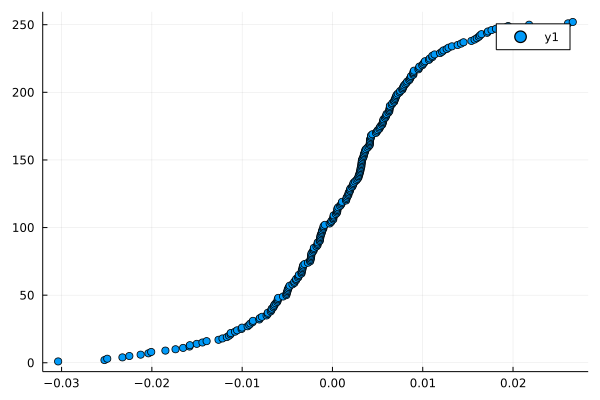

In [ ]:
resid = sort(output[:,1] - output[:,2])
scatter(resid,1:size(resid,1), kind="scatter")

#### Correlation

In [ ]:
cor(output[:,1],output[:,2])

-0.05412085360526592

### Multiple Parameters Analysis

####  Correlations

In [ ]:
# inputs
ticker = "^GSPC"
start_date = "2021-01-01"
end_date = "2021-12-31"
k_min = 3
k_max = 10
n_min = 10
n_max = 20
m_min = 40
m_max = 80
iteration = zeros(m_max-m_min+1,n_max-n_min+1)
heat = zeros(m_max-m_min+1,n_max-n_min+1)

# iteration
for k in k_min:k_max
    for n in (n_min:n_max)
        for m in (m_min:m_max)
            output_iteration = knn_simple(ticker,start_date,end_date,n,m,k)
            iteration[m-m_min+1,n-n_min+1] = cor(output_iteration[:,1],output_iteration[:,2])
        end
    end
    heat = heat + iteration
end
heat = (heat) * (1/ (k_max - k_min + 1))

41×11 Matrix{Float64}:
  0.0129832    0.0212433    0.00781529   …   0.0787914     0.0597816
  0.00564146   0.0152046    0.000916351      0.0545442     0.0410219
  0.00370041   0.00746229   0.00225013       0.0571859     0.0424349
  0.0172308    0.0234745    0.00505589       0.0630824     0.0470736
  0.0117219    0.0174994   -0.00262476       0.0630773     0.0412457
  0.00880196   0.0164125   -0.00974487   …   0.0544333     0.0357683
  0.0121719    0.0100267   -0.0146289        0.0448686     0.0237999
  0.00470598   0.0037315   -0.0196936        0.0386662     0.0219576
 -0.00986838  -0.0100503   -0.0320544        0.0250923     0.0120952
 -0.0179818   -0.0133566   -0.0347818        0.0165645     0.00662906
 -0.0236646   -0.0183515   -0.0467656    …   0.000969739   0.000997555
 -0.0366573   -0.0339992   -0.059519         0.00378226    0.00867281
 -0.0466967   -0.0371349   -0.0647866       -0.00702288   -0.00135014
  ⋮                                      ⋱                 ⋮
 -0.0277336   

#### Heatmap

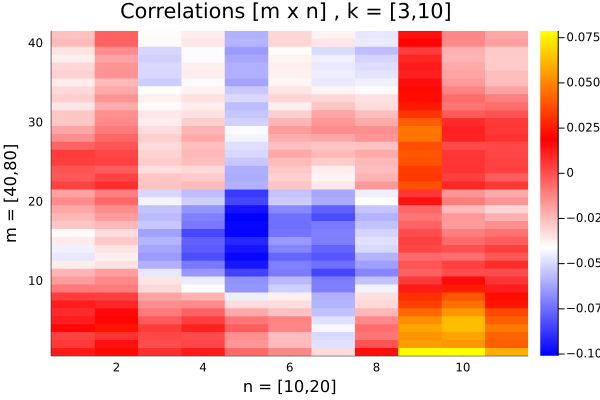

In [ ]:
gr()
plot!(heatmap(1:size(heat,2),
1:size(heat,1), heat,
c=cgrad([:blue, :white,:red, :yellow]),
xlabel="n = [$(n_min),$(n_max)]", ylabel="m = [$(m_min),$(m_max)]",
title="Correlations [m x n] , k = [$(k_min),$(k_max)] "))

### Backtest

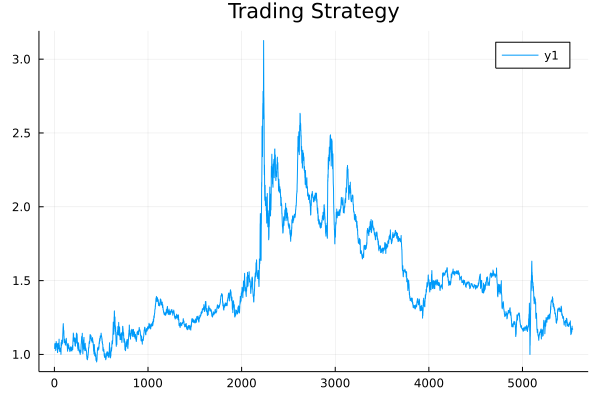

In [ ]:
# Parameters
ticker = "^GSPC"
start_date = "2000-01-01"
end_date = "2021-12-31"
n = 10
m = 100
k = 5

# KNN 
output = knn_simple(ticker,start_date,end_date,n,m,k)

# Signal Function
for i in 1:size(output)[1]
    if output[i,2] >=0
        output[i,2] = 1
    else
        output[i,2] = -1
    end
end

# Strategy Returns
strategy_returns = zeros(0)
for i in 1:size(output)[1]
    if output[i,2] == 1
        strategy_returns = append!(strategy_returns,output[i,1])
    else
        strategy_returns = append!(strategy_returns,-output[i,1])
    end
end

# Strategy Results
backtest = cumprod(strategy_returns .+ 1)
plot(backtest, kind="scatter", mode="lines", x=:Time, y=:Performance, title="Trading Strategy")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9cecfbfb-8d14-4fe7-bf0a-9433d2d86c46' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>